In [1]:
import numpy as np
import xarray as xr
import xrft
import gsw
import os.path as op
import dask.array.fft as fft
from dask.diagnostics import ProgressBar
from oceanmodes import instability_analysis_from_N2_profile as insta
from oceanmodes import neutral_modes_from_N2_profile as neu
from scipy.interpolate import PchipInterpolator as pchip
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [2]:
ddir = '/swot/SUM02/channel_seasonality/Dalma_Dar02km/runs/'
takadir = '/swot/SUM02/takaya/channelMOC-Darwin/'
avisodir = '/swot/SUM03/avisoftp.cnes.fr/AVISO/pub/jason-2/gdr_d'

In [3]:
ys, dy = (4,1)
dt = 4e1
# df = 288
ts = int(360*86400*(ys+.5)/dt)
te = int(ts+360*86400*dy/dt)
print(ts,te)

3499200 4276800


In [4]:
f0 = -1.1e-4
beta = 1.4e-11
g = 9.81
r0 = 1e3
alpha = 2e-4

In [6]:
dsTave = open_mdsdataset(ddir, 
#                        grid_dir=op.join(ddir,'02km_grid'),
                       iters=range(ts+64800,te+64800,64800), 
                       prefix=['Ttave'], delta_t=dt
                       )
dsday = open_mdsdataset(ddir, 
#                         grid_dir=op.join(ddir,'02km_grid'),
                       iters=range(ts+2160,te+2160,2160), 
                       prefix=['MOMtave'], delta_t=dt
                       )

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [8]:
dsday.coords['seas'] = ('time',np.tile(np.repeat(np.roll(range(4),-2),90),dy))
phisea = dsday.PHIHYD.groupby('seas').mean(['time','XC'])
dsTave.coords['seas'] = ('time',np.tile(np.repeat(np.roll(range(4),-2),3),dy))
dTsea = dsTave.groupby('seas').mean(['time','XC','XG'])
dTsea

<xarray.Dataset>
Dimensions:  (YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, seas: 4)
Coordinates:
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...
  * YG       (YG) >f4 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    drC      (Zp1) float64 0.5 1.07 1.22 1.395 1.595 1.815 2.065 2.35 2.67 ...
    drF      (Z) >f4 1.0 1.14 1.3 1.49 1.7 1.93 2.2 2.5 2.84 3.21 3.63 4.1 ...
    PHrefC   (Z) >f4 4.905 15.4017 27.3699 41.05485 56.7018 74.50695 94.7646 ...
    PHrefF   (Zp1) >f4 0.0 9.81 20.9934 33.7464 48.3633 65.0403 83.9736 ...
  * seas     (seas) int64 0 1 2 3
Data variables:
    Ttave    (seas, Z, YC) float32 dask.array<shape=(4, 76, 1000

In [10]:
grid = Grid(dsday, periodic=['X'])
fC = f0 + beta*(phisea.YC-1000e3)
# phi_seas = dsave_seas.PHIHYD
ug = -grid.diff(phisea,'Y',boundary='fill')/grid.diff(phisea.YC,'Y',boundary='fill')
# vg = grid.diff(phi_seas,'X')/grid.diff(phi_seas.XC,'X')
ug = grid.interp(ug,'Y',boundary='fill') * fC**-1
ug

<xarray.DataArray (seas: 4, Z: 76, YC: 1000)>
dask.array<shape=(4, 76, 1000), dtype=float32, chunksize=(1, 76, 1)>
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 1000.0 3000.0 5000.0 7000.0 9000.0 11000.0 13000.0 ...

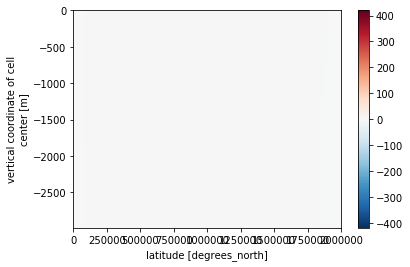

In [36]:
ug.mean('seas').plot()

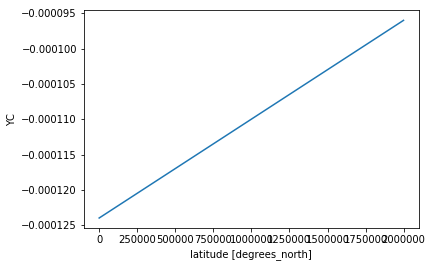

In [31]:
fC.plot()

In [11]:
with ProgressBar():
    N2_seas = alpha*g * (grid.diff(dTsea.Ttave,'Z',boundary='fill')
                        / grid.diff(dTsea.Z,'Z',boundary='fill')
                        ).compute()
N2_seas

[########################################] | 100% Completed |  2.2s


<xarray.DataArray (seas: 4, Zl: 76, YC: 1000)>
array([[[-0.000000e+00, -3.408648e-03, ..., -3.120467e-02, -3.123735e-02],
        [-0.000000e+00, -2.376483e-06, ...,  4.060306e-04,  3.989729e-04],
        ...,
        [-0.000000e+00,  5.480284e-08, ...,  2.557144e-06,  2.519483e-06],
        [-0.000000e+00,  1.865808e-08, ...,  5.128652e-07,  4.922418e-07]],

       [[-0.000000e+00, -3.453529e-03, ..., -3.113937e-02, -3.119675e-02],
        [-0.000000e+00, -2.405774e-06, ...,  3.823978e-04,  3.894512e-04],
        ...,
        [-0.000000e+00,  5.815442e-08, ...,  2.627179e-06,  2.581400e-06],
        [-0.000000e+00,  2.035646e-08, ...,  5.469988e-07,  5.183988e-07]],

       [[-0.000000e+00, -3.413652e-03, ..., -3.105370e-02, -3.112764e-02],
        [-0.000000e+00, -2.413862e-06, ...,  5.040531e-04,  5.104840e-04],
        ...,
        [-0.000000e+00,  5.242426e-08, ...,  2.413895e-06,  2.399702e-06],
        [-0.000000e+00,  1.515442e-08, ...,  4.376183e-07,  4.152564e-07]],

       [

In [14]:
kx = np.logspace(-6,-3,100)
nznew = 200
zNew = np.linspace(dTsea.Zl[0], dTsea.Zl[-1], nznew)
func = pchip(np.abs(dTsea.Zl), N2_seas.sel(YC=slice(9e5,11.02e5)), axis=1)
N2intp = xr.DataArray(func(np.abs(zNew)), dims=['seas','znew','YC'],
                     coords={'seas':N2_seas.seas.data,'znew':zNew,
                             'YC':N2_seas.YC.sel(YC=slice(9e5,11.02e5))}
                     )

In [37]:
zUew = np.linspace(dTsea.Z[0], dTsea.Z[-1], nznew)
func = pchip(np.abs(dTsea.Z), ug.sel(YC=slice(9e5,11.02e5)), axis=1)
ugintp = xr.DataArray(func(np.abs(zUew)), dims=['seas','znew','YC'],
                     coords={'seas':range(4),'znew':zUew,
                             'YC':ug.YC.sel(YC=slice(9e5,11.02e5))}
                     )

In [39]:
ugintp.YC[::5]

<xarray.DataArray 'YC' (YC: 21)>
array([ 901000.,  911000.,  921000.,  931000.,  941000.,  951000.,  961000.,
        971000.,  981000.,  991000., 1001000., 1011000., 1021000., 1031000.,
       1041000., 1051000., 1061000., 1071000., 1081000., 1091000., 1101000.],
      dtype=float32)
Coordinates:
  * YC       (YC) >f4 901000.0 911000.0 921000.0 931000.0 941000.0 951000.0 ...
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    coordinate:     YC XC
    axis:           Y

In [16]:
kd = np.zeros(4)
kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nznew*10, 'iteration': nznew*100, 'tolerance': 0}
for i in range(len(N2_seas.seas)):
    zf, Rd, neuphi = neu(np.abs(zNew[1:]), N2intp.sel(YC=10e5,method='nearest')[i,1:], 
                        np.abs(f0), np.abs(dTsea.Zp1.data[-1]),
                        **kwargs
                        )
    kd[i] = (2*np.pi*Rd[1])**-1
kd

/home/takaya/oceanmodes/oceanmodes/baroclinic.py:202: RuntimeWarning: invalid value encountered in power
  Rd = (-w)**-0.5 / np.absolute(f0)


array([1.16327468e-05, 1.13970503e-05, 1.16953804e-05, 1.17238030e-05])

In [29]:
(kd*2*np.pi)**-1*1e-3

array([13.68163052, 13.96457324, 13.60835968, 13.57536825])

In [50]:
kd*2*np.pi*1e3

array([0.0730907 , 0.07160978, 0.07348424, 0.07366283])

In [17]:
num = 2
omega = np.zeros((len(ug.seas),len(kx), len(ugintp.YC[::5])), dtype=np.complex128)
# psi = np.zeros((len(ug.seas),len(kx), 11), dtype=np.complex128)
for i in range(len(ug.seas)):
    for j in range(len(ugintp.YC[::5])):
        zpsi, gr, psi = insta(np.abs(zNew[1:]), N2intp[:,:,::5][i,1:,j].data, 
                             np.abs(f0), beta, 2*np.pi*kx, np.zeros(1),
                             np.abs(zUew), ugintp[:,:,::5][i,:,j].data, np.zeros_like(zUew),
                             np.zeros(2), np.zeros(2), sort='LI', num=num
                             )
        omega[i,:,j] = gr[0,0]

In [41]:
N2h = np.zeros(4)
Ldh = np.zeros(4)
Ri_1h = np.zeros(4)
for i in range(4):
    k=0
    while k < 10:
        if N2_seas.sel(YC=10e5,method='nearest')[i,k] >= 0.:
            break
        k += 1
    N2h[i] = (N2_seas[i].sel(YC=10e5,method='nearest')
             * np.abs(grid.diff(dsday.Z,'Z',boundary='fill'))
             )[k:].sum('Zl') * np.abs(dsday.Zp1[-1])**-1 
    Ldh[i] = 2*(np.abs(dsday.Zp1.data[-1])*np.sqrt(N2h[i])*np.abs(f0)**-1)
    Ri_1h[i] = (((grid.diff(ug[i],'Z',boundary='fill') / grid.diff(ug.Z,'Z',boundary='fill'))**2
                / N2_seas[i] * dsday.drC.data[:-1,np.newaxis]
                ).sel(YC=10e5,method='nearest')
               )[k:].sum('Zl') * np.abs(dsday.Zp1[-1])**-1
    
print(N2h, Ldh, Ri_1h)

mu = np.pi*(kd**-1)[:,np.newaxis] * kx
sigmady = np.abs(f0)*np.sqrt(Ri_1h)[:,np.newaxis] * np.sqrt((np.tanh(.5*mu)**-1 - .5*mu)*(.5*mu - np.tanh(.5*mu)))
sigmady

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/dask/local.py:253: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


[3.13659940e-06 2.99311519e-06 2.77443010e-06 2.84368387e-06] [96602.43931228 94367.02871286 90854.2941916  91981.23198717] [1.28471021e-04 7.56432209e-04 4.00944583e-05 1.25451035e-04]


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


array([[9.62580315e-08, 1.03063208e-07, 1.10325107e-07, 1.18068616e-07,
        1.26318552e-07, 1.35099227e-07, 1.44433884e-07, 1.54343981e-07,
        1.64848271e-07, 1.75961644e-07, 1.87693661e-07, 2.00046733e-07,
        2.13013824e-07, 2.26575610e-07, 2.40696927e-07, 2.55322358e-07,
        2.70370737e-07, 2.85728275e-07, 3.01239934e-07, 3.16698482e-07,
        3.31830459e-07, 3.46277825e-07, 3.59573366e-07, 3.71106600e-07,
        3.80074414e-07, 3.85405432e-07, 3.85635612e-07, 3.78683945e-07,
        3.61395490e-07, 3.28430833e-07, 2.68645520e-07, 1.40986919e-07,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,         

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


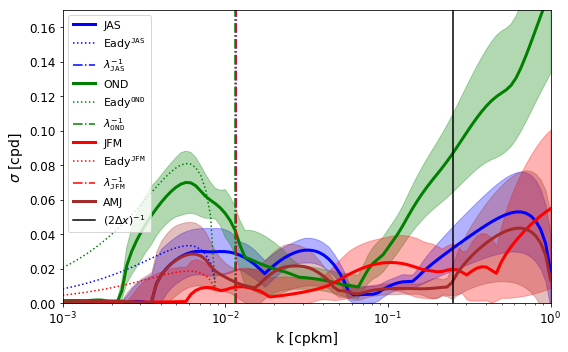

In [48]:
colors = np.roll(['red','brown','blue','green'],-2)
seasons = np.roll(['JFM','AMJ','JAS','OND'],-2)
ymax= .17
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)
for i in range(4):
    ax.plot(kx*1e3, omega[i,:,10].imag*86400, 
           color=colors[i], lw=3, label=r'%3s' % seasons[i])
    ax.fill_between(kx*1e3, (omega[i,:,10].imag-omega[i].imag.std(axis=-1))*86400,
                   (omega[i,:,10].imag+omega[i].imag.std(axis=-1))*86400,
                   color=colors[i], alpha=0.3)
    if i<3:
        ax.plot(kx*1e3, sigmady[i]*86400, color=colors[i], ls=':',
               label=r'Eady$^{\tt %3s}$' % seasons[i])
        ax.plot(kd[i]*np.ones(5)*1e3, np.linspace(0.,ymax,5), 
               color=colors[i], ls='-.', label=r'$\lambda^{-1}_{\tt %3s}$' % seasons[i])
#         ax.plot(Ldml[i]**-1*np.ones(5)*1e3, np.linspace(0.,0.08,5), 
#                color=colors[i], ls='-.', label=r'${\lambda^{ML}_{%3s}}^{-1}$' % seasons[i])
#         ax.plot(kx*1e3, sigmladyw[i]*86400, color=colors[i], ls='--',
#                label=r'$\sigma_{ML\ Eady}^{%3s}$' % seasons[i])
ax.plot((2*np.diff(dsday.XC)[0])**-1*np.ones(5)*1e3, np.linspace(0.,ymax,5), 
        'k-', label=r'(2$\Delta x$)$^{-1}$')
ax.set_ylim([0.,ymax])
ax.set_xlim([1e-3,1e0])
ax.set_xscale('log')
ax.set_xlabel(r"k [cpkm]", fontsize=14)
ax.set_ylabel(r"$\sigma$ [cpd]", fontsize=14)
ax.legend(loc='upper left', fontsize=11)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'../Figures/Growthrate_dx2km_Y1000km.pdf'))